# Import Libraries

In [5]:
!pip install tensorflow
!pip install plt
!pip install scikit-image
!pip install sklearn

     |██████████████████████          | 314.6 MB 121.9 MB/s eta 0:00:02

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 458.3 MB 109.7 MB/s eta 0:00:01     |████████████████████████████████| 458.3 MB 12 kB/s               
     |████████████████████████████████| 4.0 MB 92.5 MB/s            
     |████████████████████████████████| 65 kB 6.2 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 57 kB 8.0 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 42 kB 2.2 MB/s             
     |████████████████████████████████| 5.6 MB 70.4 MB/s            
     |████████████████████████████████| 462 kB 92.2 MB/s            
     |████████████████████████████████| 1.3 MB 25.1 MB/s            
     |████████████████████████████████| 4.0 MB 67.8 MB/s            
     |████████████████████████████████| 288 kB 83.9 MB/s            
     |████████████████████████████████| 152 kB 92.2 MB/s            
     |████████████████████████████████| 4.9 MB 74.2 MB/s            
     |█████████████

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from skimage import feature
from sklearn import neighbors


# Retrieve Dataset

In [7]:
from preprocess import retrieve_dataset, preprocess, to_np

(train_ds_raw, test_ds_raw), metadata = retrieve_dataset(should_shuffle_files=True)

train_ds = preprocess(train_ds_raw, {
  'is_undersample_negative': True,
  'reduce_dataset_to': 0,
  'is_grayscale': False, 
  'is_downsample64': False,
  'is_downsample128': False, 
  'is_normalize': False,
})

test_ds = preprocess(test_ds_raw, {
  'is_undersample_negative': True,
  'reduce_dataset_to': 0,
  'is_grayscale': False, 
  'is_downsample64': False, 
  'is_downsample128': False, 
  'is_normalize': False,
})

def count_class(counts, batch):
    labels = batch[1]
    for i in range(9):
        cc = tf.cast(labels == i, tf.int32)
        counts[i] += tf.reduce_sum(cc)
    return counts

initial_state = dict((i, 0) for i in range(9))
counts = train_ds.reduce(initial_state=initial_state,
                         reduce_func=count_class)

print("Class breakdown for train dataset:")
print([(k, v.numpy()) for k, v in counts.items()])

initial_state = dict((i, 0) for i in range(9))
counts = test_ds.reduce(initial_state=initial_state,
                         reduce_func=count_class)

print("Class breakdown for test dataset:")
print([(k, v.numpy()) for k, v in counts.items()])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/17509 [00:00<?, ? examples/s]

Shuffling deep_weeds-train.tfrecord...:   0%|          | 0/17509 [00:00<?, ? examples/s]

Dataset deep_weeds downloaded and prepared to /home/songyu98/tensorflow_datasets/deep_weeds/3.0.0. Subsequent calls will reuse this data.
Class breakdown for train dataset:
[(0, 891), (1, 853), (2, 818), (3, 819), (4, 845), (5, 809), (6, 856), (7, 781), (8, 834)]
Class breakdown for test dataset:
[(0, 234), (1, 211), (2, 213), (3, 203), (4, 217), (5, 200), (6, 218), (7, 235), (8, 216)]


# Extract X_train, Y_train, X_test, Y_test

In [8]:
train_ds_numpy = to_np(train_ds)
test_ds_numpy = to_np(test_ds)

In [9]:
X_train = [example for example, label in train_ds_numpy]
y_train = [label for example, label in train_ds_numpy]

X_test = [example for example, label in test_ds_numpy]
y_test = [label for example, label in test_ds_numpy]

# Visualize Preprocessed Dataset

Length of X_train: 7506
Length of X_test: 1947


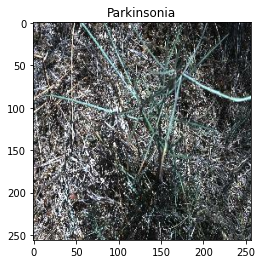

In [10]:
from visualize import visualize, compare

visualize(X_train[0], y_train[0], metadata)
print(f'Length of X_train: {len(X_train)}')
print(f'Length of X_test: {len(X_test)}')

# Perform Transfer Learning

In [11]:
from transfer_learning import init_conv_base, extract_features
conv_base = init_conv_base(X_train[0])

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [12]:
train_features, train_labels = extract_features(conv_base, X_train, y_train)  # Agree with our small dataset size
test_features, test_labels = extract_features(conv_base, X_test, y_test)

# Flatten To Feed into KNN

In [13]:
X_train_flatten = list(map(lambda x: x.flatten(), train_features))
y_train = train_labels
X_test_flatten = list(map(lambda x: x.flatten(), test_features))
y_test = test_labels

print(train_labels.shape)
print("feature size now:", X_train[0].shape) # orginal feature is of dimension 196608

(7506,)
feature size now: (256, 256, 3)


# Test Model with K Fold Validation

In [14]:
import importlib
import run_algo_with_kfold
importlib.reload(run_algo_with_kfold)
from run_algo_with_kfold import kfold_cross_validation

In [18]:
import math
def round_up_to_odd(f):
    return np.ceil(f) // 2 * 2 + 1

nearest_root_of_training_instances = int(round_up_to_odd(math.sqrt(len(X_train))))
print(nearest_root_of_training_instances)

87


In [19]:
n_neighbors_arr = [5, 15, 50, nearest_root_of_training_instances]
metric_arr = ['euclidean', 'manhattan', 'minkowski']
k = 5
accuracies = []

for n_neighbors in n_neighbors_arr:
  curr_neighbors_arr = []
  accuracies.append(curr_neighbors_arr)
  for metric in metric_arr:
    curr_neighbors_arr.append(kfold_cross_validation(k, X_train_flatten, y_train, 'knn', {'n_neighbors': n_neighbors, 'metric': metric}))

highest_accuracy = 0
best_n = 0
best_metric = ''

for neighbor_idx, lst in enumerate(accuracies):
  for metric_idx, accuracy in enumerate(lst):
    if accuracy > highest_accuracy:
      best_n = n_neighbors_arr[neighbor_idx]
      best_metric = metric_arr[metric_idx]
      highest_accuracy = accuracy

print(f'Best n: {best_n}, best metric: {best_metric}')

Running 5-fold cross validation for knn with {'n_neighbors': 5, 'metric': 'euclidean'}
Split accuracy: 0.4793608521970706
Split accuracy: 0.47368421052631576
Split accuracy: 0.4596935376415723
Split accuracy: 0.47168554297135246
Split accuracy: 0.46169220519653564
Completed 5-fold cross validation for knn with {'n_neighbors': 5, 'metric': 'euclidean'}
Obtained average accuracy of: 0.46922326970656936

Running 5-fold cross validation for knn with {'n_neighbors': 5, 'metric': 'manhattan'}
Split accuracy: 0.4533954727030626
Split accuracy: 0.44770153231179216
Split accuracy: 0.45569620253164556
Split accuracy: 0.4576948700866089
Split accuracy: 0.43704197201865425
Completed 5-fold cross validation for knn with {'n_neighbors': 5, 'metric': 'manhattan'}
Obtained average accuracy of: 0.4503060099303527

Running 5-fold cross validation for knn with {'n_neighbors': 5, 'metric': 'minkowski'}
Split accuracy: 0.4793608521970706
Split accuracy: 0.47368421052631576
Split accuracy: 0.459693537641572

Maximum accuracy:- [0.46922326970656936, 0.4503060099303527, 0.46922326970656936] at K = 0


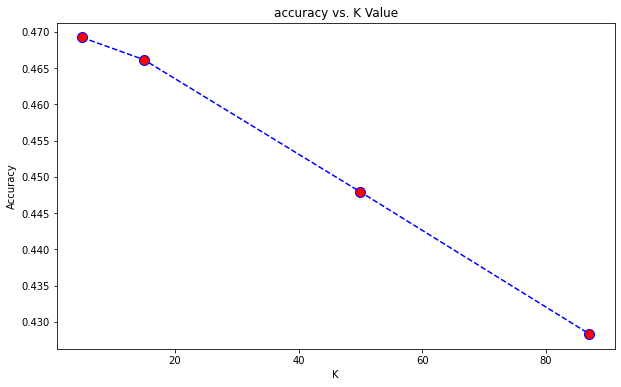

In [23]:
plt.figure(figsize=(10,6))
plt.plot(n_neighbors_arr,list(map(max, accuracies)),color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(accuracies),"at K =",accuracies.index(max(accuracies)))

In [24]:
import importlib
import run_algo_with_kfold
importlib.reload(run_algo_with_kfold)
from run_algo_with_kfold import get_precision_scores, get_roc_auc_curve, visualize_roc_auc_curve, train_model

In [25]:
model = train_model('knn', {'n_neighbors': best_n, 'metric': best_metric}, X_train_flatten, y_train, True)

In [26]:
print(get_precision_scores(model, X_test_flatten, y_test))

{'accuracy': 0.480225988700565, 'macro_avg': 0.5238049517557748, 'f1_score_macro': 0.4831816444707988, 'micro_avg': 0.480225988700565, 'f1_score_micro': 0.480225988700565, 'roc_auc_score': 0.8221579246213175}


In [27]:
(fpr, tpr, roc_auc) = get_roc_auc_curve(model, X_train_flatten, y_train, X_test_flatten, y_test, {'is_svm': False})


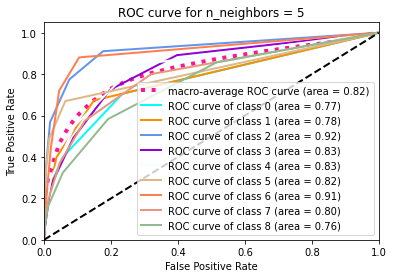

In [28]:
import importlib
import run_algo_with_kfold
importlib.reload(run_algo_with_kfold)
from run_algo_with_kfold import visualize_roc_auc_curve

title = f'ROC curve for n_neighbors = {str(best_n)}'
visualize_roc_auc_curve(title, fpr, tpr, roc_auc, len(np.unique(y_test)))